# 음성데이터 augmentation

## Load Data & Plot Data

In [1]:
import numpy as np
import random
import itertools
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import soundfile as sf  # soundfile 라이브러리를 추가

(216737,)


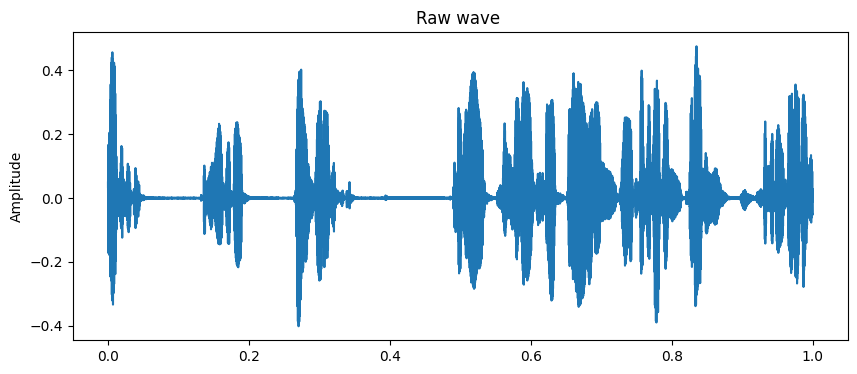

In [2]:
def plot_time_series(data):
    fig = plt.figure(figsize=(10, 4))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()

data, sr = librosa.load('input.wav', sr=22050)

print(data.shape)
plot_time_series(data)

## 1. Adding White Noise

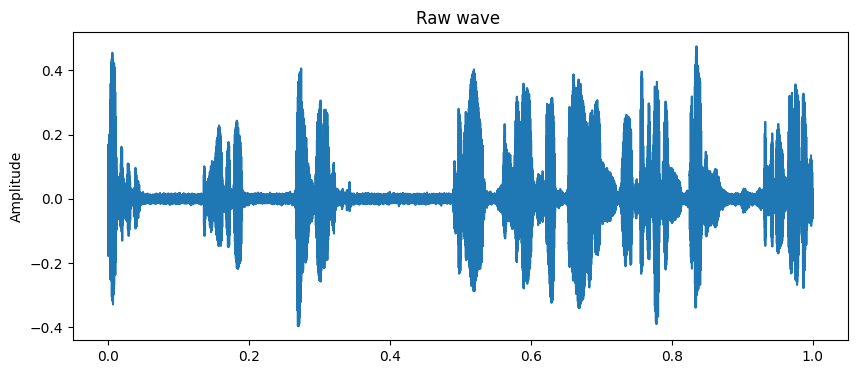

White Noise 저장 성공


array([0.03448812, 0.0516396 , 0.04611227, ..., 0.01943914, 0.01567049,
       0.        ], dtype=float32)

In [3]:
def adding_white_noise(data, sr=22050, noise_rate=0.005):
    # noise 방식으로 일반적으로 쓰는 잡음 끼게 하는 겁니다.
    wn = np.random.randn(len(data))
    data_wn = data + noise_rate*wn
    plot_time_series(data_wn)
    # librosa.output.write_wav 대신 soundfile 라이브러리의 write 함수를 사용합니다.
    sf.write('white_noise.wav', data_wn, sr)  # 수정된 부분
    print('White Noise 저장 성공')
    
    return data

adding_white_noise(data)

## 1-1. Adding Partial_White_Noise

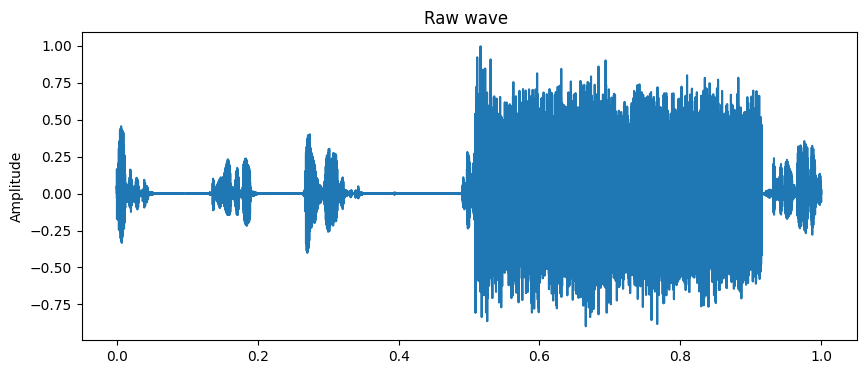

부분적으로 White Noise 삽입 성공


array([0.03448812, 0.0516396 , 0.04611227, ..., 0.01943914, 0.01567049,
       0.        ], dtype=float32)

In [7]:
def adding_white_noise_partially(data, start_time, end_time, sr=22050, noise_rate=0.2): # noise_rate 크기 조정 -> 노이즈 소리 조정
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)
    
    # 오직 특정 구간에만 노이즈를 추가.
    data_with_noise = np.copy(data)
    data_with_noise[start_sample:end_sample] += noise_rate * np.random.randn(end_sample - start_sample)
    
    plot_time_series(data_with_noise)
    sf.write('partial_white_noise.wav', data_with_noise, sr)
    print('부분적으로 White Noise 삽입 성공')
    
    return data_with_noise

# 예를 들어, 오디오의 5초부터 9초까지의 구간에 노이즈를 추가하고 싶다면:
adding_white_noise_partially(data, 5, 9)

## 2. Shifting the sound

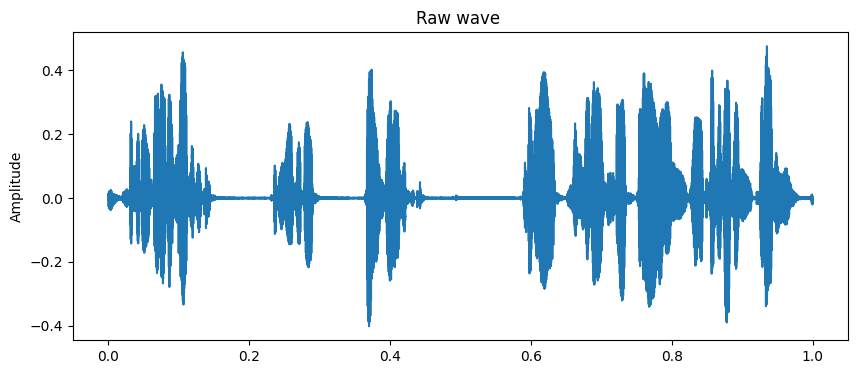

rolling_sound 저장 성공


array([0.03448812, 0.0516396 , 0.04611227, ..., 0.01943914, 0.01567049,
       0.        ], dtype=float32)

In [5]:
def shifting_sound(data, sr=22050, roll_rate=0.1):
    # 그냥 [1, 2, 3, 4] 를 [4, 1, 2, 3]으로 만들어주는겁니다.
    data_roll = np.roll(data, int(len(data) * roll_rate))
    plot_time_series(data_roll)
    # librosa.output.write_wav 대신 soundfile 라이브러리의 write 함수를 사용합니다.
    sf.write('rolling_noise.wav', data_roll, sr)  # 수정된 부분
    print('rolling_sound 저장 성공')
    
    return data
    
shifting_sound(data)

참고: https://github.com/smothly/High_Perfomance_Python/tree/master